# USS Reviews Data Cleaning

This notebook processes the raw USS Reviews dataset and creates a cleaned "Silver" layer dataset according to the Medallion Architecture.

## Process Overview:
1. Load the raw (Bronze) data
2. Perform data cleaning
3. Transform to Silver layer format
4. Save the result

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to the path to enable imports
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project-specific modules
from src.data.loader import load_raw_data, validate_raw_data, get_column_summary
from src.data.cleaner import (
    remove_empty_records, clean_text_field,
    remove_special_chars,
    process_translated_text, integrate_review_context
)
from src.data.transformer import (
    select_columns_for_silver,
    anonymize_user_data, extract_standardized_dates, transform_to_silver
)

## 1. Load and Explore the Raw Data

In [2]:
# Set paths
raw_data_dir = '../data/raw'
silver_data_dir = '../data/processed'

In [3]:
raw_csv_filename = 'USS_Reviews_Raw_100k.csv'
raw_csv_path = os.path.join(raw_data_dir, raw_csv_filename)

# Load raw data
df_bronze = load_raw_data(raw_csv_path)

# Validate data
validate_raw_data(df_bronze)

# Display basic info
print(f"Raw data shape: {df_bronze.shape}")
df_bronze.head()

/Users/miracler/Documents/Studying/Postgraduate Course/Major Courses/CS605-NLP for Smart Assistants/project/CS605-NLP-Project/src/data/loader.py:25: DtypeWarning: Columns (26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Renamed columns: ['reviewContext/Visited on', 'reviewContext/Wait time'] -> ['visit_date', 'wait_time']
Successfully loaded 77999 records with 103 columns
Data validation: 34101 of 77999 records have both text and stars
Raw data shape: (77999, 103)


,address,categories/0,categories/1,categories/2,categoryName,cid,city,countryCode,fid,imageUrl,...,state,street,temporarilyClosed,text,textTranslated,title,totalScore,translatedLanguage,url,visitedIn
0,"8 Sentosa Gateway, Singapore 098269",Theme park,Amusement park,Tourist attraction,Theme park,3500426646667023007,Singapore,SG,0x31da1955a615a343:0x3094037d34e6529f,https://lh3.googleusercontent.com/gps-cs-s/AC9...,...,NaN,8 Sentosa Gateway,False,NaN,NaN,Universal Studios Singapore,4.6,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
1,"8 Sentosa Gateway, Singapore 098269",Theme park,Amusement park,Tourist attraction,Theme park,3500426646667023007,Singapore,SG,0x31da1955a615a343:0x3094037d34e6529f,https://lh3.googleusercontent.com/gps-cs-s/AC9...,...,NaN,8 Sentosa Gateway,False,Awesome,NaN,Universal Studios Singapore,4.6,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
2,"8 Sentosa Gateway, Singapore 098269",Theme park,Amusement park,Tourist attraction,Theme park,3500426646667023007,Singapore,SG,0x31da1955a615a343:0x3094037d34e6529f,https://lh3.googleusercontent.com/gps-cs-s/AC9...,...,NaN,8 Sentosa Gateway,False,Nice lot if activities need entire day to cove...,NaN,Universal Studios Singapore,4.6,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
3,"8 Sentosa Gateway, Singapore 098269",Theme park,Amusement park,Tourist attraction,Theme park,3500426646667023007,Singapore,SG,0x31da1955a615a343:0x3094037d34e6529f,https://lh3.googleusercontent.com/gps-cs-s/AC9...,...,NaN,8 Sentosa Gateway,False,Universal Studios Singapore offers an unforget...,NaN,Universal Studios Singapore,4.6,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
4,"8 Sentosa Gateway, Singapore 098269",Theme park,Amusement park,Tourist attraction,Theme park,3500426646667023007,Singapore,SG,0x31da1955a615a343:0x3094037d34e6529f,https://lh3.googleusercontent.com/gps-cs-s/AC9...,...,NaN,8 Sentosa Gateway,False,Mummy ride was great but cost way too much for...,NaN,Universal Studios Singapore,4.6,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN


In [4]:
# Get column summary
column_summary = get_column_summary(df_bronze)

# Display columns with less than 50% null values
column_summary[column_summary['Null %'] < 50].sort_values('Null %')

,Column,Type,Non-Null Count,Null %,Unique Values
0,address,object,77999,0.0,1
23,publishAt,object,77999,0.0,44
24,publishedAtDate,object,77999,0.0,77973
32,reviewId,object,77999,0.0,77973
83,reviewOrigin,object,77999,0.0,1
84,reviewUrl,object,77999,0.0,77973
85,reviewerId,object,77999,0.0,77973
86,reviewerNumberOfReviews,int64,77999,0.0,1052
21,postalCode,int64,77999,0.0,1
87,reviewerPhotoUrl,object,77999,0.0,77973


## 2. Perform Step-by-Step Data Cleaning

In [5]:
# Step 1: Process translated text
df_clean = process_translated_text(df_bronze)

# Check how many records used translated text
if 'review' in df_clean.columns:
    print(f"Records with review field: {df_clean['review'].notna().sum()}")

Detecting language for text column...
Created review field: 21427 records used original English text
7987 records used translated text
Filtered out 48585 rows (62.29%) without valid review text
Records with review field: 29414


In [6]:
# Step 2: Integrate review context
df_clean = integrate_review_context(df_clean)

# Compare original text and integrated text
text_context_comparison = pd.DataFrame({
    'Original Text': df_clean['review'].head(5),
    'Integrated Text': df_clean['integrated_review'].head(5)
})
text_context_comparison

Created integrated_review field with context information


,Original Text,Integrated Text
0,Nice lot if activities need entire day to cove...,Nice lot if activities need entire day to cove...
1,Universal Studios Singapore offers an unforget...,Universal Studios Singapore offers an unforget...
2,Mummy ride was great but cost way too much for...,Mummy ride was great but cost way too much for...
3,We went there to enjoy the Minions.\nIt's hot ...,We went there to enjoy the Minions.\nIt's hot ...
4,Universal Studio's famous Playland Singapore.,Universal Studio's famous Playland Singapore. ...


In [7]:
# Step 3: Remove empty records
df_clean = remove_empty_records(df_clean, required_columns=['review', 'stars', 'integrated_review', 'publishAt'])
print(f"After removing empty records: {df_clean.shape}")

Removed 0 records (0.00%) with missing values in ['review', 'stars', 'integrated_review', 'publishAt']
After removing empty records: (29414, 105)


In [8]:
# Step 4: Clean text field
df_clean = clean_text_field(df_clean, text_cols=['review', 'integrated_review'])
df_clean = remove_special_chars(df_clean, text_cols=['review', 'integrated_review'])

Text cleaning for review: 0 text fields became empty after cleaning
Text cleaning for integrated_review: 0 text fields became empty after cleaning
Special character removal for review: 2 text fields became empty after cleaning
Special character removal for integrated_review: 2 text fields became empty after cleaning
Found 2 rows with null values in text columns. Removing these rows.
Rows removed: 2. Remaining rows: 29412


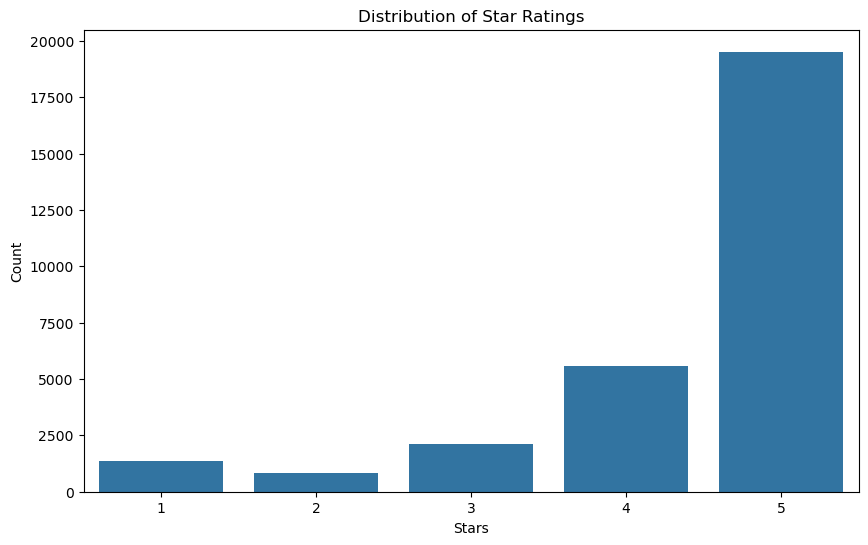

In [9]:
# Step 5: Distribution of stars
if 'stars' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='stars', data=df_clean)
    plt.title('Distribution of Star Ratings')
    plt.xlabel('Stars')
    plt.ylabel('Count')
    plt.show()

## 3. Transform to Silver Layer

In [10]:
# Extract standard date from publishedAtDate column

df_silver = extract_standardized_dates(df_clean, date_col='publishedAtDate')

# Show a sample of converted times
sample_times = pd.DataFrame({
    'Original': df_clean['publishedAtDate'].astype(str).head(10),
    'Converted': df_silver['publishedAtDate'].head(10)
})
display(sample_times)

Converted 29412 dates to standard format (YYYY-MM-DD)


,Original,Converted
0,2025-05-23T11:12:18.934Z,2025-05-23
1,2025-05-23T10:49:56.433Z,2025-05-23
2,2025-05-23T10:19:04.297Z,2025-05-23
3,2025-05-23T09:22:23.795Z,2025-05-23
4,2025-05-23T08:25:48.377Z,2025-05-23
5,2025-05-23T08:16:19.081Z,2025-05-23
6,2025-05-23T08:11:09.740Z,2025-05-23
7,2025-05-23T06:33:16.137Z,2025-05-23
8,2025-05-23T05:27:04.790Z,2025-05-23
9,2025-05-23T05:26:15.056Z,2025-05-23


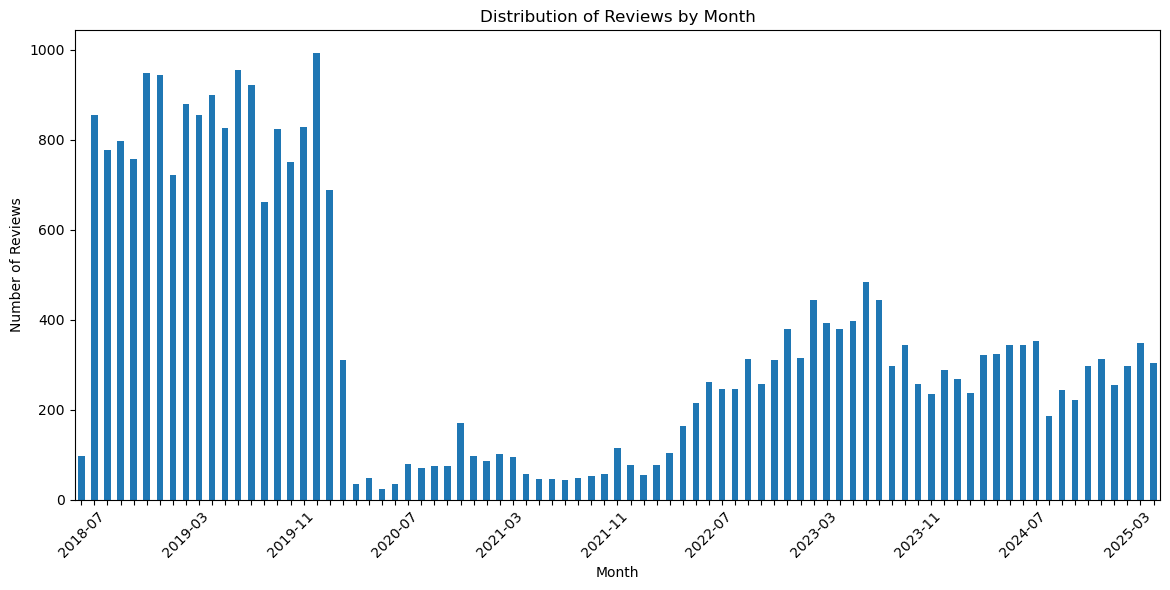

Time span: 2018-07-29 00:00:00 to 2025-05-23 00:00:00
Most active month: 2020-01 with 994 reviews


In [11]:
# Check if publishedAtDate exists in the dataframe
if 'publishedAtDate' in df_silver.columns:
    # Create a copy for visualization purposes
    plot_data = pd.DataFrame({'publishedAtDate': df_silver['publishedAtDate']})
    
    # Ensure the data is in datetime format
    plot_data['publishedAtDate'] = pd.to_datetime(plot_data['publishedAtDate'])
    
    # Group reviews by month and count occurrences
    monthly_counts = plot_data['publishedAtDate'].dt.to_period('M').value_counts().sort_index()
    monthly_counts.index = monthly_counts.index.astype(str)
    
    # Create bar plot of reviews per month
    plt.figure(figsize=(12, 6))
    ax = monthly_counts.plot(kind='bar')
    plt.title('Distribution of Reviews by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # If there are too many x labels, show only a subset
    if len(monthly_counts) > 20:
        every_nth = len(monthly_counts) // 10
        for i, label in enumerate(ax.xaxis.get_ticklabels()):
            if i % every_nth != 0:
                label.set_visible(False)
    
    plt.show()
    
    # Calculate time statistics for reporting
    min_date = plot_data['publishedAtDate'].min()
    max_date = plot_data['publishedAtDate'].max()
    most_active_month = monthly_counts.idxmax()
    most_active_count = monthly_counts.max()
    
    print(f"Time span: {min_date} to {max_date}")
    print(f"Most active month: {most_active_month} with {most_active_count} reviews")
else:
    print("publishedAtDate column not found in the dataset")

In [12]:
# Select columns for Silver layer
silver_columns = [
    'name', 'stars',
    'review', 'integrated_review', 'publishedAtDate'
]

# Filter columns that exist in the dataframe
available_silver_columns = [col for col in silver_columns if col in df_silver.columns]
df_silver = select_columns_for_silver(df_silver, available_silver_columns)

print(f"Silver layer columns: {df_silver.columns.tolist()}")

Selected 5 columns for Silver layer: ['name', 'stars', 'review', 'integrated_review', 'publishedAtDate']
Silver layer columns: ['name', 'stars', 'review', 'integrated_review', 'publishedAtDate']


In [13]:
# Anonymize user data
df_silver = anonymize_user_data(df_silver, columns_to_anonymize=['name'])

print(f"Anonymization complete: Sample of anonymized names")
print(df_silver['name'].head(10))

Anonymized 28953 unique values in column: name
Anonymization complete: Sample of anonymized names
0    user_0
1    user_1
2    user_2
3    user_3
4    user_4
5    user_5
6    user_6
7    user_7
8    user_8
9    user_9
Name: name, dtype: object


In [14]:
# Add a unique index
df_silver.reset_index(drop=True, inplace=True)
df_silver['review_index'] = df_silver.index

# Final check of Silver layer
print(f"Final Silver layer shape: {df_silver.shape}")
df_silver.head()

Final Silver layer shape: (29412, 6)


,name,stars,review,integrated_review,publishedAtDate,review_index
0,user_0,4,Nice lot if activities need entire day to cove...,Nice lot if activities need entire day to cove...,2025-05-23,0
1,user_1,5,Universal Studios Singapore offers an unforget...,Universal Studios Singapore offers an unforget...,2025-05-23,1
2,user_2,2,Mummy ride was great but cost way too much for...,Mummy ride was great but cost way too much for...,2025-05-23,2
3,user_3,4,We went there to enjoy the Minions. It's hot d...,We went there to enjoy the Minions. It's hot d...,2025-05-23,3
4,user_4,5,Universal Studio's famous Playland Singapore.,Universal Studio's famous Playland Singapore. ...,2025-05-23,4


## 4. Save the Silver Layer Data

In [15]:
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(silver_data_dir), exist_ok=True)

silver_csv_filename = 'USS_Reviews_Silver.csv'
silver_parquet_fileanme = 'USS_Reviews_Silver.parquet'

silver_csv_path = os.path.join(silver_data_dir, silver_csv_filename)
silver_parquet_path = os.path.join(silver_data_dir, silver_parquet_fileanme)

# Save to CSV
df_silver.to_csv(silver_csv_path, index=False)
print(f"Saved Silver layer csv data to {silver_csv_path}")

# Save to Parquet
df_silver.to_parquet(silver_parquet_path, index=False)
print(f"Saved Silver layer parquet data to {silver_parquet_path}")

Saved Silver layer csv data to ../data/processed/USS_Reviews_Silver.csv
Saved Silver layer parquet data to ../data/processed/USS_Reviews_Silver.parquet


## One Step for data cleaning (Optional)

In [16]:
transform_to_silver(df_bronze, output_path=silver_data_dir)

Starting transformation from Bronze to Silver layer
Detecting language for text column...
Created review field: 21427 records used original English text
7987 records used translated text
Filtered out 48585 rows (62.29%) without valid review text
Created integrated_review field with context information
Removed 0 records (0.00%) with missing values in ['review', 'stars', 'integrated_review', 'publishedAtDate']
Text cleaning for review: 0 text fields became empty after cleaning
Text cleaning for integrated_review: 0 text fields became empty after cleaning
Special character removal for review: 2 text fields became empty after cleaning
Special character removal for integrated_review: 2 text fields became empty after cleaning
Found 2 rows with null values in text columns. Removing these rows.
Rows removed: 2. Remaining rows: 29412
Converted 29412 dates to standard format (YYYY-MM-DD)
Selected 5 columns for Silver layer: ['integrated_review', 'stars', 'name', 'review', 'publishedAtDate']
Anon

,integrated_review,stars,name,review,publishedAtDate,review_index
0,Nice lot if activities need entire day to cove...,4,user_0,Nice lot if activities need entire day to cove...,2025-05-23,0
1,Universal Studios Singapore offers an unforget...,5,user_1,Universal Studios Singapore offers an unforget...,2025-05-23,1
2,Mummy ride was great but cost way too much for...,2,user_2,Mummy ride was great but cost way too much for...,2025-05-23,2
3,We went there to enjoy the Minions. It's hot d...,4,user_3,We went there to enjoy the Minions. It's hot d...,2025-05-23,3
4,Universal Studio's famous Playland Singapore. ...,5,user_4,Universal Studio's famous Playland Singapore.,2025-05-23,4
...,...,...,...,...,...,...
29407,Fun! Prices are expensive and queues are long!,4,user_28948,Fun! Prices are expensive and queues are long!,2018-07-29,29407
29408,"I have also been to the LA version of it, henc...",4,user_28949,"I have also been to the LA version of it, henc...",2018-07-29,29408
29409,"An hour of wait time for almost every ride, ev...",2,user_28950,"An hour of wait time for almost every ride, ev...",2018-07-29,29409
29410,Such a happy place to visit.,4,user_28951,Such a happy place to visit.,2018-07-29,29410


## 5. Data Quality Check

In [18]:
# Perform data quality checks on Silver layer
def check_data_quality(df):
    print("Data Quality Report:")
    print(f"- Total records: {len(df)}")
    
    # Missing values by column
    missing_by_col = df.isna().sum()
    print("\nMissing values by column:")
    print(missing_by_col[missing_by_col > 0])
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
# Run quality check
check_data_quality(df_silver)

Data Quality Report:
- Total records: 29412

Missing values by column:
Series([], dtype: int64)

Data types:
name                 object
stars                 int64
review               object
integrated_review    object
publishedAtDate      object
review_index          int64
dtype: object
